# Chargement des données

In [1]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gensim
from gensim.models import word2vec

random.seed(1)
np.random.seed(1)

In [2]:
os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres')
#os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')

In [3]:
nom_dossier = 'ens'
dim = 100
epoch = 100
window = 4
learning_rate = 0.02
    
chemin1 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed1".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model1 = gensim.models.keyedvectors.KeyedVectors.load(chemin1 + "/word2vec.model")
chemin2 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed5".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model2 = gensim.models.keyedvectors.KeyedVectors.load(chemin2 + "/word2vec.model")
chemin3 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed10".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model3 = gensim.models.keyedvectors.KeyedVectors.load(chemin3 + "/word2vec.model")
chemin4 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed15".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model4 = gensim.models.keyedvectors.KeyedVectors.load(chemin4 + "/word2vec.model")
chemin5 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed20".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:])  
model5 = gensim.models.keyedvectors.KeyedVectors.load(chemin5 + "/word2vec.model")
chemin6 = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed25".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:]) 
model6 = gensim.models.keyedvectors.KeyedVectors.load(chemin6 + "/word2vec.model")

In [4]:
matrice = {word : (model1.wv[word]+model2.wv[word]+model3.wv[word]+model4.wv[word]+model5.wv[word]+model6.wv[word])/6
           for word in model1.wv.index2word}

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

matrice_norm = {word : normalize(matrice[word]) for word in matrice.keys()}

# Modèle logit : identifier mal prédits + distribution proba

In [46]:
# Si on veut récup les fichiers
with open("data/sentimental_analysis/corpus_test_2.file", "rb") as f:
    corpus_test = pickle.load(f)
with open("data/sentimental_analysis/corpus_train_2.file", "rb") as f:
    corpus_train = pickle.load(f)

def calcul_sentence_embedding(phrase):
    if len(phrase)>0:
        #sum1 = sum(matrice[mot] for mot in phrase if mot in model1.wv.index2word)
        sum1 = sum(matrice_norm[mot] for mot in phrase if mot in model1.wv.index2word)
        #sum2 = sum(matrice["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        sum2 = sum(matrice_norm["lowfrequencyword"] for mot in phrase if mot not in model1.wv.index2word)
        return (sum1+sum2)/len(phrase)
    else:
        return matrice["lowfrequencyword"]

In [47]:
phrases = [[tweet.split(),score] for (score, tweet) in corpus_train]
phrases_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases]
Y_train = [score for (score, embedding) in phrases_emb]
X_train = [embedding for (score, embedding) in phrases_emb]

In [48]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
reg_log = lr.fit(X_train,Y_train)

C:\Users\torna\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
Y_train_pred = reg_log.predict(X_train)

from sklearn import metrics
# Matrice confusion
cm = metrics.confusion_matrix(Y_train,Y_train_pred)
print(cm)
# Accuracy
acc = metrics.accuracy_score(Y_train,Y_train_pred)
print(acc) 

[[17792  7208]
 [ 8039 16961]]
0.69506


In [54]:
phrases_test = [[tweet.split(),score] for (score, tweet) in corpus_test]
phrases_test_emb = [[score,calcul_sentence_embedding(phrase)] for (phrase,score) in phrases_test]
Y_test = [score for (score, embedding) in phrases_test_emb]
X_test = [embedding for (score, embedding) in phrases_test_emb]
Y_test_pred = reg_log.predict(X_test)

# Matrice confusion
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 

[[1426  558]
 [ 698 1300]]
0.6845806127574083


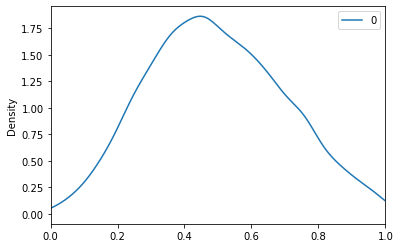

In [55]:
probas = reg_log.predict_proba(X_test)[:,1]
pd.DataFrame(probas).plot(kind='density',xlim=(0,1)) 

## Focus sur tweets mal prédits

In [99]:
phrases_pred = [(tweet,score,pred,proba) for (tweet,score),pred,proba in zip(phrases_test,Y_test_pred,probas)]
phrases_pos_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == 1 and pred==-1)]
phrases_neg_faux = [[tweet,proba] for (tweet,score,pred,proba) in phrases_pred if (score == -1 and pred==1)]

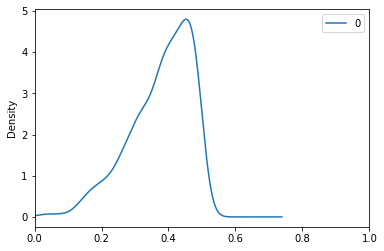

In [109]:
probas_pos = [proba for [tweet,proba] in phrases_pos_faux]
pd.DataFrame(probas_pos).plot(kind='density',xlim=(0,1))

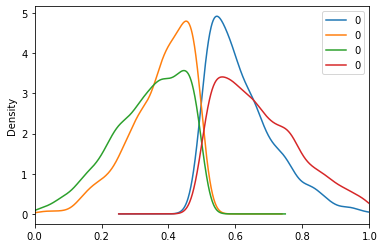

In [118]:
probas_neg = [proba for [tweet,proba] in phrases_neg_faux]
ax = plt.gca()
pd.DataFrame(probas_neg).plot(kind='density',xlim=(0,1),ax=ax)
pd.DataFrame(probas_pos).plot(kind='density',xlim=(0,1),ax=ax)
pd.DataFrame(probas[probas<0.5]).plot(kind='density',xlim=(0,1),ax=ax) 
pd.DataFrame(probas[probas>0.5]).plot(kind='density',xlim=(0,1),ax=ax) 
plt.show()

In [152]:
mots = [mot for (tweet,score) in phrases_test for mot in tweet]
voc_faux = list(dict.fromkeys(mots))
app_voc = {mot : [0,0,0,0] for mot in voc_faux}

In [153]:
for phrase, score in phrases_test:
    for mot in phrase:
        plus, moins,faux_plus,faux_moins = app_voc[mot]
        if score == 1:
            app_voc[mot] = [plus+1,moins,faux_plus,faux_moins]
        else:
            app_voc[mot] = [plus,moins+1,faux_plus,faux_moins]
            
for [tweet, proba] in phrases_pos_faux:
    for mot in tweet:
        plus, moins,faux_plus,faux_moins = app_voc[mot]
        app_voc[mot] = [plus,moins,faux_plus+1,faux_moins]
        
for [tweet, proba] in phrases_neg_faux:
    for mot in tweet:
        plus, moins,faux_plus,faux_moins = app_voc[mot]
        app_voc[mot] =  [plus,moins,faux_plus,faux_moins+1]

In [172]:
donnees = [val for val in app_voc.values()]
mots = [mot for mot in app_voc.keys()]
df = pd.DataFrame(donnees,index=mots,columns=["Phrases positives","Phrases négatives","Phrases positives mal prédites","Phrases négatives mal prédites"])

In [173]:
df["Pourcentage pos"] =df["Phrases positives mal prédites"]/ df["Phrases positives"]
df["Pourcentage neg"] =df["Phrases négatives mal prédites"]/ df["Phrases négatives"]
df.sort_values(by=['Pourcentage pos'],ascending=False)

,Phrases positives,Phrases négatives,Phrases positives mal prédites,Phrases négatives mal prédites,Pourcentage pos,Pourcentage neg
unité,1,0,1,0,1.0,NaN
puissions,1,1,1,0,1.0,0.0
tendances,1,0,1,0,1.0,NaN
remarquer,1,1,1,0,1.0,0.0
graphiques,1,0,1,0,1.0,NaN
...,...,...,...,...,...,...
flamboyant,0,1,0,0,NaN,0.0
importance,0,1,0,0,NaN,0.0
avancer,0,1,0,0,NaN,0.0
marburg,0,1,0,1,NaN,1.0


In [176]:
df.to_csv('test.csv', sep = ';',encoding='UTF8')

In [183]:
def compte(phrase):
    compteur = 0
    for mot in phrase:
        if mot not in model1.wv.index2word:
            compteur = compteur + 1
    return compteur

phrases_pos_faux_compt = [[phrase,compte(phrase),len(phrase)] for [phrase,score] in phrases_pos_faux]
phrases_neg_faux_compt = [[phrase,compte(phrase),len(phrase)] for [phrase,score] in phrases_neg_faux]

In [186]:
phrases_pos_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_pos_faux_compt if val2>0]
phrases_neg_faux_pourcent = [[phrase,val1/val2] for [phrase,val1,val2] in phrases_neg_faux_compt if val2>0]

In [192]:
val_pos_faux_pourcent = [val for [phrase,val] in phrases_pos_faux_pourcent]
val_neg_faux_pourcent = [val for [phrase,val] in phrases_neg_faux_pourcent]

In [215]:
df_pos = pd.DataFrame(val_pos_faux_pourcent,columns=["val"])
print(df_pos[df_pos["val"]>0].shape)
print(df_pos.shape)

(234, 1)
(698, 1)


In [216]:
df_neg = pd.DataFrame(val_neg_faux_pourcent,columns=["val"])
print(df_neg[df_neg["val"]>0].shape)
print(df_neg.shape)

(255, 1)
(557, 1)


# Modèle probit

In [52]:
from statsmodels.discrete.discrete_model import Probit
Y_train_prob = [max(val,0) for val in Y_train]
model = Probit(Y_train_prob, X_train)
probit_model = model.fit()

Optimization terminated successfully.
         Current function value: 0.583535
         Iterations 6


[[1440  544]
 [ 703 1295]]
0.6868407835258664


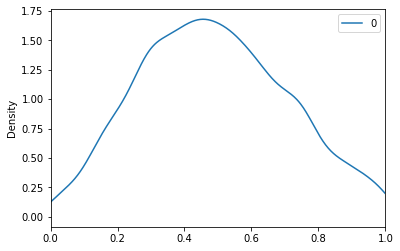

In [53]:
Y_test_pred = probit_model.predict(X_test)
pd.DataFrame(Y_test_pred).plot(kind='density',xlim=(0,1))
Y_test_pred = [1 if (val >= 0.5) else -1 for val in Y_test_pred]
cm_test = metrics.confusion_matrix(Y_test,Y_test_pred)
print(cm_test)
# Accuracy
acc_test = metrics.accuracy_score(Y_test,Y_test_pred)
print(acc_test) 